# A Sentiment Analysis of MLB Performance

In [1]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install tqdm

In [23]:
#Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import numpy as np
import seaborn as sns

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

##### The first step is to scrape the text from the blog posts from the mlbtraderumors.com website. The posts include text, dates posted, and the authors name, all of which will be scraped before storing into a dataframe to use and start the text analysis.

# Acquire Text Data

In [3]:
def scrape_website(url, file_path):
    # Send a GET request to the website
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the news article elements
    articles = soup.find_all("article")

    # Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    # Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            # Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            # Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            # Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            # Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            # Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    # Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)

    # Drop rows without content
    df.dropna()

    return df

# Oakland Athletics Data Collection and Cleaning

In [4]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/oakland-athletics?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_oakland_athletics_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
df = scrape_website(url, file_path)
df.head()

,Title,Author,Date,Content
0,A’s Claim Angel Felipe,Steve Adams,"June 21, 2023",The Athletics have claimed right-hander Angel ...
1,Athletics Select Yacksel Ríos,Darragh McDonald,"June 20, 2023",The Athletics announced that they have selecte...
2,Dick Hall Passes Away,Darragh McDonald,"June 19, 2023",The Orioles have announced that former major l...
3,A’s Acquire Yacksel Rios,Nick Deeds,"June 18, 2023",6:56 PM: As noted by Justin Toscano of the Atl...
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,"June 18, 2023",The Red Sox are looking to acquire an infielde...


In [5]:
# Change the Data column to a datetime object:
df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')

In [6]:
df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [7]:
# Check for missing values
df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [8]:
len(df)

1030

In [9]:
df = df.dropna()
df

,Title,Author,Date,Content
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,The Athletics have claimed right-hander Angel ...
1,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selecte...
2,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major l...
3,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,6:56 PM: As noted by Justin Toscano of the Atl...
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,The Red Sox are looking to acquire an infielde...
...,...,...,...,...
995,"Forst: A's Expect Luzardo To Be ""A Factor"" Nex...",Steve Adams,2018-10-08,While some Athletics fans were hoping for a lo...
996,"A’s Notes: Davis, Melvin, Lucroy, Lowrie, Kelley",Mark Polishuk,2018-10-05,"After falling short in the AL wild card game, ..."
997,How Jonathan Lucroy Has Helped The A's,Mark Polishuk,2018-10-03,Jonathan Lucroy didn’t contribute much at the ...
998,A's To Start Liam Hendriks In Wild-Card Game,Connor Byrne,2018-10-02,The Yankees and Athletics have named their sta...


In [10]:
len(df)

1000

## Import data on the Oakland Athletics from baseball-reference.com.

https://www.baseball-reference.com/teams/OAK/attend.shtml

In [11]:
# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/OAK/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv


In [12]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

athletics_df = pd.DataFrame(pd.read_csv(path + 'athletics_statistics.csv'))
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,56,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",95,93,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum


In [13]:
athletics_df= athletics_df[athletics_df['Year'] > 2004]
athletics_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,56,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",95,93,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum
5,2018,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1573616.0,19427.0,13th of 15,"$69,883,333",97,97,Oakland-Alameda County Coliseum
6,2017,Oakland Athletics,AL West,75,87,5,NaN,1475721.0,18219.0,14th of 15,"$51,560,000",95,95,Oakland-Alameda County Coliseum
7,2016,Oakland Athletics,AL West,69,93,5,NaN,1521506.0,18784.0,14th of 15,"$54,969,067",97,96,Oakland-Alameda County Coliseum
8,2015,Oakland Athletics,AL West,68,94,5,NaN,1768175.0,21829.0,12th of 15,"$64,016,001",97,97,O.co Coliseum
9,2014,Oakland Athletics,AL West,88,74,2,Lost ALWC (1-0),2003628.0,24736.0,10th of 15,"$89,160,900",97,98,O.co Coliseum


In [14]:
# Remove the dollar and comma signs from the following columns:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\$':''}, regex = True)
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\,':''}, regex = True)
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,56,5,NaN,368146.0,9688.0,15th of 15,51230000,95,93,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334,95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834,95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333,94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833,93,94,Oakland-Alameda County Coliseum


In [15]:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].astype(float)
athletics_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

## Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [16]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
athletics_df['success'] = (athletics_df['W'] / (athletics_df['W'] + athletics_df['L']) >= 0.5).astype(int)
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Oakland Athletics,AL West,19,56,5,NaN,368146.0,9688.0,15th of 15,51230000.0,95,93,RingCentral Coliseum,0
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334.0,95,93,RingCentral Coliseum,0
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834.0,95,95,RingCentral Coliseum,1
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333.0,94,96,Oakland-Alameda County Coliseum,1
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833.0,93,94,Oakland-Alameda County Coliseum,1


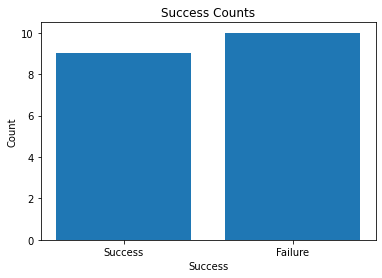

In [17]:
# Count the number of successes and failures
success_counts = athletics_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

In [18]:
athletics_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,76.157895,75.842105,2.894737,1.518666e+06,19041.388889,6.754905e+07,96.157895,96.157895,0.526316
std,5.627314,20.456629,17.426873,1.523692,4.682565e+05,5114.775012,1.597226e+07,1.893356,2.061907,0.512989
min,2005.000000,19.000000,24.000000,1.000000,3.681460e+05,8660.000000,4.796713e+07,93.000000,93.000000,0.000000
25%,2009.500000,71.500000,67.000000,2.000000,1.432724e+06,17688.000000,5.519741e+07,95.000000,94.500000,0.000000
50%,2014.000000,76.000000,76.000000,3.000000,1.619436e+06,19993.000000,6.484308e+07,97.000000,96.000000,1.000000
75%,2018.500000,90.500000,87.000000,4.500000,1.799020e+06,22210.000000,7.462514e+07,97.000000,98.000000,1.000000
max,2023.000000,97.000000,102.000000,5.000000,2.109118e+06,26038.000000,1.029358e+08,100.000000,100.000000,1.000000


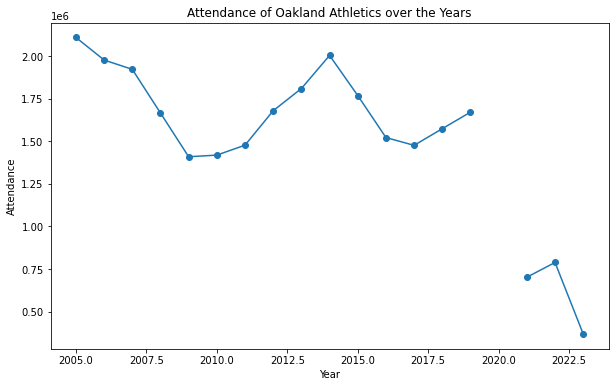

In [19]:
# Plotting the data
# Convert columns to numpy arrays
year = np.array(athletics_df['Year'])
attendance = np.array(athletics_df['Attendance'])

plt.figure(figsize=(10, 6))

# Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Oakland Athletics over the Years')

# Display the plot
plt.show()

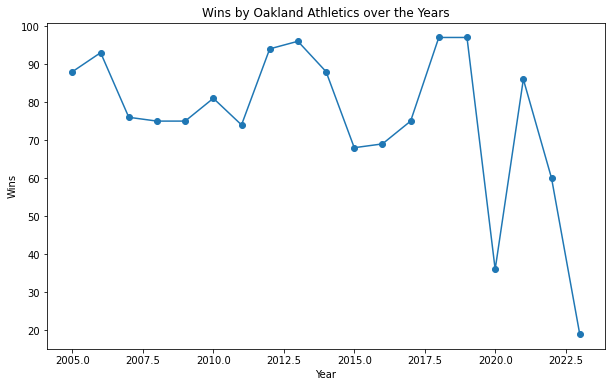

In [20]:
# Plotting Wins over the years
year = np.array(athletics_df['Year'])
wins = np.array(athletics_df['W'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Oakland Athletics over the Years')

# Display the plot
plt.show()

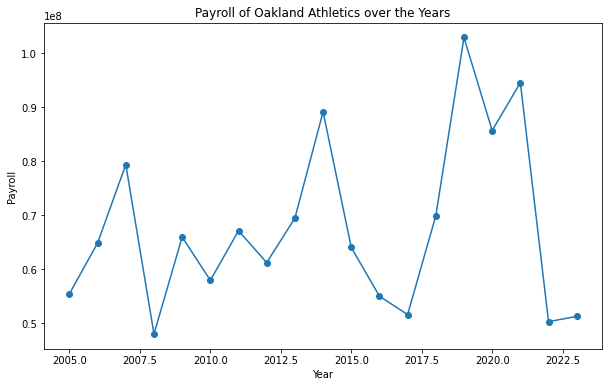

In [21]:
# Plotting Payroll over the years
# Convert columns to numpy arrays
year = np.array(athletics_df['Year'])
payroll = np.array(athletics_df['Est. Payroll'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Oakland Athletics over the Years')

# Display the plot
plt.show()

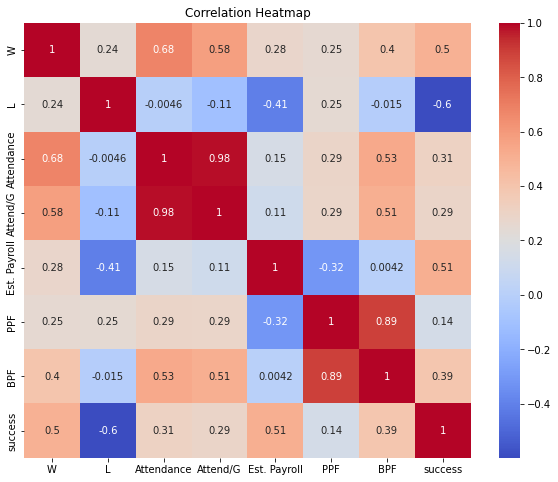

In [24]:
# Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = athletics_df[numeric_cols]

# Correlation matrix
correlation = numeric_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

#### Add column to analyze whether blog post occurred in a successful year or not.

In [25]:
# Extract the year from the "Date" column in df DataFrame
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Merge df and nats_df DataFrames on the "Year" column
merged_df = pd.merge(df, athletics_df[['Year', 'success']], on='Year', how='left')

# Add a new column 'Year_Successful' based on 'success' column
merged_df['Year_Successful'] = merged_df['success'].fillna(0).astype(int)

merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,The Athletics have claimed right-hander Angel ...,2023,0,0
1,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selecte...,2023,0,0
2,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major l...,2023,0,0
3,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,6:56 PM: As noted by Justin Toscano of the Atl...,2023,0,0
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,The Red Sox are looking to acquire an infielde...,2023,0,0


In [26]:
len(merged_df)

1000

# Cleaning the Data

In [27]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [28]:
merged_df['Content'].apply

<bound method Series.apply of 0      The Athletics have claimed right-hander Angel ...
1      The Athletics announced that they have selecte...
2      The Orioles have announced that former major l...
3      6:56 PM: As noted by Justin Toscano of the Atl...
4      The Red Sox are looking to acquire an infielde...
                             ...                        
995    While some Athletics fans were hoping for a lo...
996    After falling short in the AL wild card game, ...
997    Jonathan Lucroy didn’t contribute much at the ...
998    The Yankees and Athletics have named their sta...
999    Sept. 28: The A’s announced tonight that Trigg...
Name: Content, Length: 1000, dtype: object>

In [29]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_df['impurity'] = merged_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
113,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
946,Left-handed pitching prospect Jesus Luzardo is drawing raves from both inside and outside the At...,0.004474
533,Kingston fit the mold of many of the Angels’ candidates — well-regarded younger executives who w...,0.003306


##### The steps above displays the highest impurity levels for the Athletics' data set. The impurity levels above are extremely low, being below 1% of all characters in each blog post appear suspicious.

# Character Normalization and Tokenization

In [30]:
# Example function to normalize the text in the "Contents" column
def normalize_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

# Apply normalization to the "Contents" column
merged_df["Contents_Normalized"] = merged_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_df[["Content", "Contents_Normalized"]].head()
 	

,Content,Contents_Normalized
0,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...","[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple..."
1,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti..."
2,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ..."
3,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...","[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad..."
4,"The Red Sox are looking to acquire an infielder who can play multiple positions, MassLive.com’s ...","[red, sox, look, acquir, infield, play, multipl, posit, masslivecom, sean, mcadam, write, focu, ..."


In [31]:
merged_df['length'] = merged_df['Contents_Normalized'].str.len()
merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0,0.0,"[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple...",182
1,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,2023,0,0,0.0,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti...",179
2,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,2023,0,0,0.0,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ...",173
3,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...",2023,0,0,0.0,"[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad...",206
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,"The Red Sox are looking to acquire an infielder who can play multiple positions, MassLive.com’s ...",2023,0,0,0.0,"[red, sox, look, acquir, infield, play, multipl, posit, masslivecom, sean, mcadam, write, focu, ...",84


# Analyze descriptive statistics for text in dataframe.

<Axes: >

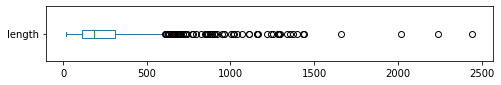

In [32]:
merged_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

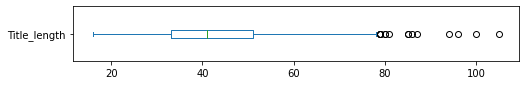

In [33]:
merged_df['Title_length'] = merged_df['Title'].str.len()
merged_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

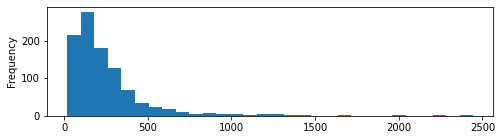

In [34]:
merged_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

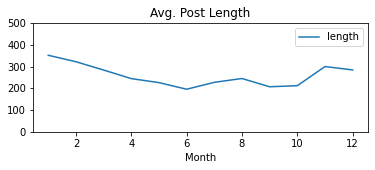

In [35]:
# Extract the month from the date and create a new column
merged_df['Month'] = merged_df['Date'].dt.month

# Plot the average post length
merged_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))


In [36]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [37]:
freq_df = count_words(merged_df)
freq_df.head(5)

,freq
token,
season,3189
year,2292
leagu,1837
mm,1595
oakland,1570


In [38]:
#How many tokens are in the df?
len(freq_df)

6654

In [39]:
# top words with 10+ characters
count_words(merged_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)

,freq
token,
appearances,733
organization,374
arbitration,368
outfielder,316
assignment,272


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

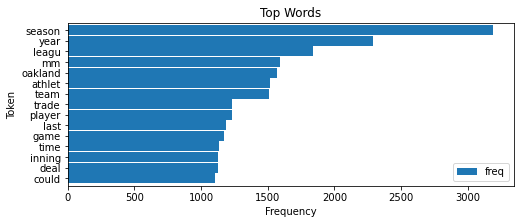

In [40]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')